## Some imports

In [1]:
import sys
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 200
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
import tensorflow as tf
import random
import numpy as np

import math
from uncertainties import ufloat
from uncertainties.umath import *

In [2]:
try:
    tf.reset_default_graph()
except AttributeError:
    tf.compat.v1.reset_default_graph()
    tf.compat.v1.disable_eager_execution()

## Check if notebook or script and import the right config

In [3]:
def in_ipynb():
    try:
        cfg = get_ipython().config
        print(cfg)
        if 'jupyter' in cfg['IPKernelApp']['connection_file']:
            return True
        else:
            return False
    except NameError:
        return False

In [4]:
if in_ipynb():
    print("In IPython")
    TrainConfig="PFPhoton"
    exec("import "+TrainConfig.replace("/", ".")+" as Conf")
else:
    TrainConfig=sys.argv[1]
    print("Importing settings from "+ TrainConfig.replace("/", "."))
    #exec("from "+TrainConfig+" import *")
    importConfig=TrainConfig.replace("/", ".")
    exec("import "+importConfig+" as Conf")

{'IPKernelApp': {'connection_file': '/home/akapoor/.local/share/jupyter/runtime/kernel-c24ffdf7-22c1-457c-a424-7512b04501da.json'}}
In IPython


## Set some default options

In [5]:
def modify(df):
    return 0
if not hasattr(Conf, 'MVAlogplot'): Conf.MVAlogplot=False
if not hasattr(Conf, 'ROClogplot'): Conf.ROClogplot=False
if not hasattr(Conf, 'Multicore'): Conf.Multicore=False
if not hasattr(Conf, 'RandomState'): Conf.RandomState=42
if not hasattr(Conf, 'flatten'): Conf.flatten=False
if not hasattr(Conf, 'testsize'): Conf.testsize=0.2
if not hasattr(Conf, 'Debug'): Conf.Debug=False
if not hasattr(Conf, 'Thresholds'):Conf.Thresholds=False
if not hasattr(Conf, 'Spectators'):Conf.Spectators=[]
if not hasattr(Conf, 'CMSLabel'):Conf.CMSLabel=["",""]
    
print(Conf.CMSLabel)

['CMS Preliminary', '13 TeV']


## Set same random state for everything

In [6]:
tf.compat.v1.random.set_random_seed(Conf.RandomState)
random.seed(Conf.RandomState)
np.random.seed(Conf.RandomState)

## Get uproot (uproot3 needed)

In [7]:
import os
os.system("")
try:
  import uproot3 as uproot
except ImportError:
  import uproot

In [8]:
import glob
import pandas as pd
import numpy as np
#import ROOT
import matplotlib.pyplot as plt
import json

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout

In [9]:
from Tools.PlotTools import *
import Tools.ptetaRwt as ptetaRwt

In [10]:
if len(Conf.Classes)>2:
    prGreen('You are running a multi-class classification: This is an experimental feature! Only ROCs, MVAs, models will saved. No thresholds available!')

if Conf.Debug==True:
    prGreen("Running in debug mode : Only every 10th event will be used")

if len(Conf.MVAs)>0:
    for MVAd in Conf.MVAs:
        os.system("mkdir -p " + Conf.OutputDirName+"/"+MVAd["MVAtype"])
prGreen("Making output directory")
os.system("mkdir -p " + Conf.OutputDirName)
os.system("mkdir -p " + Conf.OutputDirName+"/CodeANDConfig")
os.system("mkdir -p " + Conf.OutputDirName+"/Thresholds")
os.system("cp "+TrainConfig+".py ./"+ Conf.OutputDirName+"/CodeANDConfig/")
os.system("cp Trainer.py ./"+ Conf.OutputDirName+"/CodeANDConfig/")

 Making output directory


0

In [11]:
cat='Category'
weight='NewWt'
label=Conf.Classes

In [12]:
import Tools.readData as readData
import sys
import os

In [13]:
import pandas as pd
if Conf.loadfromsaved:
    df_final=pd.read_parquet(Conf.OutputDirName+'/df.parquet.gzip')
else:
    df_final=readData.daskframe_from_rootfiles(Conf.processes,Conf.Tree,branches=Conf.branches,flatten=Conf.flatten,debug=Conf.Debug)
    if hasattr(Conf, 'SaveDataFrameCSV'):
        if Conf.SaveDataFrameCSV:
            prGreen("Saving DataFrame : It can take sometime")
            df_final.to_parquet(Conf.OutputDirName+'/df.parquet.gzip',compression='gzip')

['/scratch/GJet//egmNtuple_6.root', '/scratch/GJet//egmNtuple_5.root', '/scratch/GJet//egmNtuple_3.root', '/scratch/GJet//egmNtuple_7.root', '/scratch/GJet//egmNtuple_2.root', '/scratch/GJet//egmNtuple_1.root']
['/scratch/GJet//egmNtuple_6.root', '/scratch/GJet//egmNtuple_5.root', '/scratch/GJet//egmNtuple_3.root', '/scratch/GJet//egmNtuple_7.root', '/scratch/GJet//egmNtuple_2.root', '/scratch/GJet//egmNtuple_1.root']
Creating dask graph!
Testing single file first
/scratch/GJet//egmNtuple_6.root
Finally, getting data from
/scratch/GJet//egmNtuple_6.root/scratch/GJet//egmNtuple_2.root
/scratch/GJet//egmNtuple_1.root

/scratch/GJet//egmNtuple_1.root
/scratch/GJet//egmNtuple_5.root
/scratch/GJet//egmNtuple_6.root
/scratch/GJet//egmNtuple_2.root
/scratch/GJet//egmNtuple_7.root
/scratch/GJet//egmNtuple_5.root
/scratch/GJet//egmNtuple_7.root
/scratch/GJet//egmNtuple_3.root
/scratch/GJet//egmNtuple_3.root
 Saving DataFrame : It can take sometime


In [14]:
len(df_final)

247026

In [15]:
df_final[cat]=0
for i,k in enumerate(Conf.Classes):
    df_final.loc[df_final.Class == k, cat] = i

In [16]:
try:
    Conf.modifydf(df_final)
    print("Dataframe modification is done using modifydf")
except:
    print("Looks fine")

Looks fine


In [17]:
index = df_final.index
Classes=Conf.Classes

In [18]:
from sklearn.model_selection import train_test_split

TrainIndices=[]
TestIndices=[]


In [19]:
for myclass in Classes:
    condition = df_final["Class"] == myclass
    Indices = index[condition].values.tolist()
    myclassTrainIndices, myclassTestIndices = train_test_split(Indices, test_size=Conf.testsize, random_state=Conf.RandomState, shuffle=True)
    TrainIndices=TrainIndices + myclassTrainIndices
    TestIndices=TestIndices + myclassTestIndices

In [20]:
df_final.loc[TrainIndices,'Dataset'] = "Train"
df_final.loc[TestIndices,'Dataset'] = "Test"

df_final.loc[TrainIndices,'TrainDataset'] = 1
df_final.loc[TestIndices,'TrainDataset'] = 0

In [21]:
prGreen("Reading classes:")
print(df_final.Class.unique().tolist())
#print(df_final[cat].unique().tolist())

 Reading classes:
['GoodPhotons', 'NonPrompt']


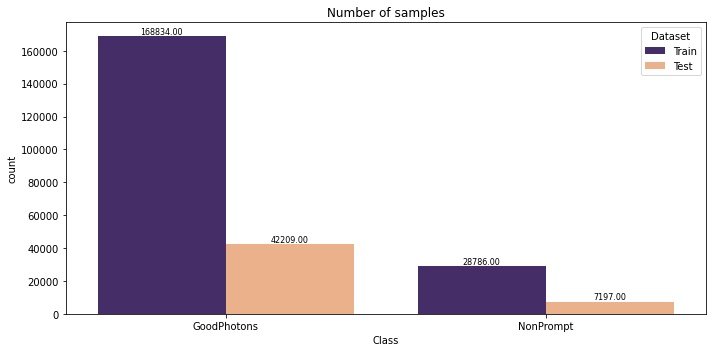

In [22]:
import seaborn as sns
fig, axes = plt.subplots(1, 1, figsize=(10, 5))
kplot=sns.countplot(x="Class", data=df_final, ax=axes,hue='Dataset',palette=['#432371',"#FAAE7B","black"])
for p in kplot.patches:
    kplot.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 5), textcoords = 'offset points',size=8)
axes.set_title("Number of samples")
#axes.set_yscale("log")
plt.savefig(Conf.OutputDirName+"/TotalStat_TrainANDTest.pdf")
plt.savefig(Conf.OutputDirName+"/TotalStat_TrainANDTest.png")

In [23]:
df_final[weight]=df_final['xsecwt']


if any(hasattr(Conf, attr) for attr in ['Reweighing', 'ptbins','ptwtvar','etawtvar','etabins','WhichClassToReweightTo'])  and Conf.Reweighing=='True':
    ReweightClass=Conf.WhichClassToReweightTo
    print("After reweighting> In Training:")
    df_final.loc[TrainIndices,weight]=ptetaRwt.df_pteta_rwt(df_final.loc[TrainIndices],"Class",
                                                   ptw=Conf.ptbins,etaw=Conf.etabins,
                                                   pt=Conf.ptwtvar,eta=Conf.etawtvar,
                                                   SumWeightCol='xsecwt',NewWeightCol=weight,
                                                   cand=ReweightClass,Classes=Conf.Classes)


# In[22]:


if hasattr(Conf, 'Reweighing') and Conf.Reweighing=='True':
    ReweightClass=Conf.WhichClassToReweightTo
    print("After reweighting> In Testing:")
    df_final.loc[TestIndices,weight]=ptetaRwt.df_pteta_rwt(df_final.loc[TestIndices],"Class",
                                                  ptw=Conf.ptbins,etaw=Conf.etabins,
                                                  pt=Conf.ptwtvar,eta=Conf.etawtvar,
                                                  SumWeightCol='xsecwt',NewWeightCol=weight,
                                                  cand=ReweightClass,Classes=Conf.Classes)
    

After reweighting> In Training:
Number of events in GoodPhotons after  weighing = 168834.0
Number of events in NonPrompt after  weighing = 168678.00000000006
After reweighting> In Testing:
Number of events in GoodPhotons after  weighing = 42209.0
Number of events in NonPrompt after  weighing = 42121.0


In [24]:
######Spectators
if len(Conf.Spectators)>0:
    MakeSpectatorPlots(df_final,Conf.Spectators,Conf.SpectatorBins,Set="Train",OutputDirName=Conf.OutputDirName,label=Conf.Classes,log=Conf.MVAlogplot)
    MakeSpectatorPlots(df_final,Conf.Spectators,Conf.SpectatorBins,Set="Test",OutputDirName=Conf.OutputDirName,label=Conf.Classes,log=Conf.MVAlogplot)

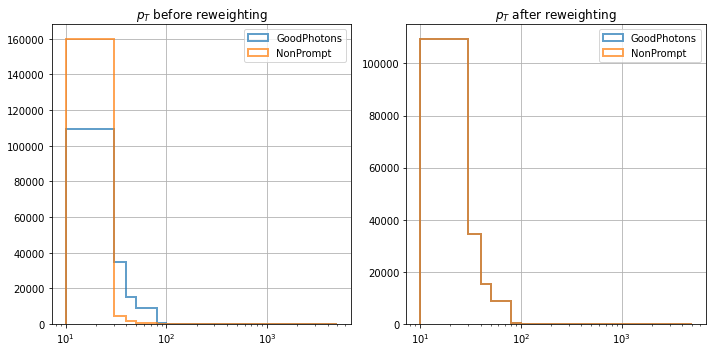

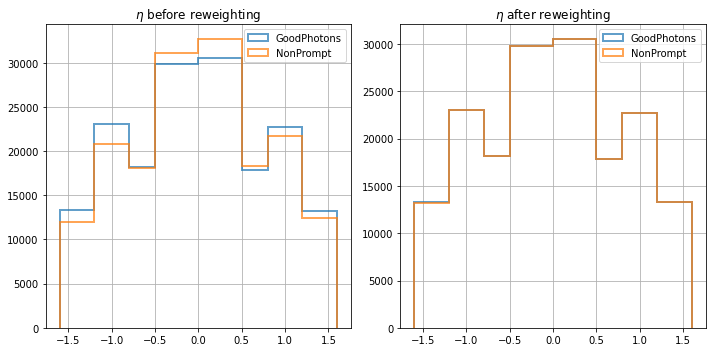

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


if any(hasattr(Conf, attr) for attr in ['Reweighing', 'ptbins','ptwtvar','etawtvar','etabins','WhichClassToReweightTo']):

    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    for i,group_df in df_final[df_final['Dataset'] == "Train"].groupby("Class"):
        group_df[Conf.ptwtvar].hist(histtype='step', bins=Conf.ptbins, alpha=0.7,label=i, ax=ax[0], density=False, ls='-', weights =group_df["xsecwt"],linewidth=2)
        ax[0].set_title("$p_T$ before reweighting")
        ax[0].legend()
        ax[0].set_xscale('log')
        group_df[Conf.ptwtvar].hist(histtype='step', bins=Conf.ptbins, alpha=0.7,label=i, ax=ax[1], density=False, ls='-', weights =group_df["NewWt"],linewidth=2)
        ax[1].set_title("$p_T$ after reweighting")
        ax[1].legend()
        ax[1].set_xscale('log')
    fig.savefig(Conf.OutputDirName+"/pT_rwt.pdf")

    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    for i,group_df in df_final[df_final['Dataset'] == "Train"].groupby("Class"):
        group_df[Conf.etawtvar].hist(histtype='step',
                                     bins=Conf.etabins,
                                     #[i for i in range(len(Conf.etabins)-1)],
                                     alpha=0.7,label=i, ax=ax[0], density=False, ls='-', weights =group_df["xsecwt"],linewidth=2)
        ax[0].set_title("$\eta$ before reweighting")
        ax[0].legend()
        group_df[Conf.etawtvar].hist(histtype='step',
                                     bins=Conf.etabins,
                                     alpha=0.7,label=i, ax=ax[1], density=False, ls='-', weights =group_df["NewWt"],linewidth=2)
        ax[1].set_title("$\eta$ after reweighting")
        ax[1].legend()
    fig.savefig(Conf.OutputDirName+"/eta_rwt.pdf")

In [26]:
def PrepDataset(df_final,TrainIndices,TestIndices,features,cat,weight):
    X_train = df_final.loc[TrainIndices,features]
    Y_train = df_final.loc[TrainIndices,cat]
    Wt_train = df_final.loc[TrainIndices,weight]

    X_test = df_final.loc[TestIndices,features]
    Y_test = df_final.loc[TestIndices,cat]
    Wt_test = df_final.loc[TestIndices,weight]
    return np.asarray(X_train), np.asarray(Y_train), np.asarray(Wt_train), np.asarray(X_test), np.asarray(Y_test), np.asarray(Wt_test)

In [27]:
import pickle
import multiprocessing
import seaborn as sns

def corre(df,Classes=[''],MVA={}):
    for C in Classes:
            for k in ["Train","Test"]:
                fig, axes = plt.subplots(1, 1, figsize=(len(MVA["features"])/2, len(MVA["features"])/2))
                cor = df.loc[(df['Dataset'] == k) & (df['Class'] == str(C))][MVA["features"]].corr()
                sns.heatmap(cor, annot=True, cmap=plt.cm.Reds,ax=axes,annot_kws={"size":len(MVA["features"])/4})
                axes.tick_params(axis='x', labelsize=len(MVA["features"])/2)
                axes.tick_params(axis='y', labelsize=len(MVA["features"])/2)
                #axes.set_xticklabels(MVA["features"],fontsize= len(MVA["features"]))
                #axes.set_yticklabels(MVA["features"],fontsize= len(MVA["features"]))
                fig.savefig(Conf.OutputDirName+"/"+MVA["MVAtype"]+"/"+MVA["MVAtype"]+"_"+C+"_CORRELATION_"+k+".png")

 Making Train dataset feature plots
 Making Test dataset feature plots
 Making Combined dataset feature plots
 XGB_1_old_list Applying MinMaxScaler
 XGB_1_old_list Training starting
 Performing XGB grid search
Fitting 3 folds for each of 1 candidates, totalling 3 fits
 Expected neg log loss of XGB model = -53.2%
 XGB Best Parameters
 {'colsample_bytree': 1.0, 'gamma': 0.5, 'max_depth': 5, 'min_child_weight': 5, 'subsample': 0.8}
{'validation_0': {'error': [0.273201, 0.273044, 0.270631, 0.266436, 0.266183, 0.259614, 0.260819, 0.262747, 0.263298, 0.26306, 0.263673, 0.26216, 0.262301, 0.263065, 0.263592, 0.26342, 0.263809, 0.263516, 0.259842, 0.260358, 0.263384, 0.262904, 0.262838, 0.261927, 0.261487, 0.261871, 0.261912, 0.262317, 0.262767, 0.26259, 0.262312, 0.261927, 0.262489, 0.262352, 0.261897, 0.261831, 0.262413, 0.261866, 0.261912, 0.261912, 0.261087, 0.261289, 0.261684, 0.260783, 0.261158, 0.261558, 0.261487, 0.261305, 0.261052, 0.261127, 0.260885, 0.260728, 0.260763, 0.260834, 0.2

<ipython-input-35-3399a3769b1b>:43: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


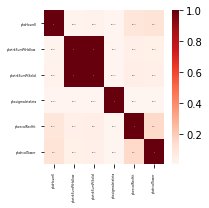

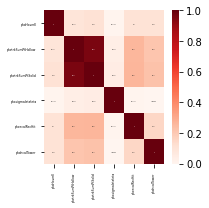

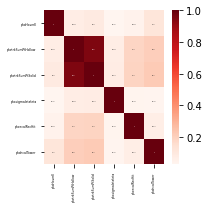

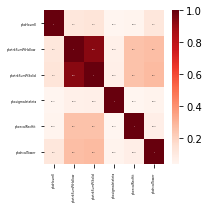

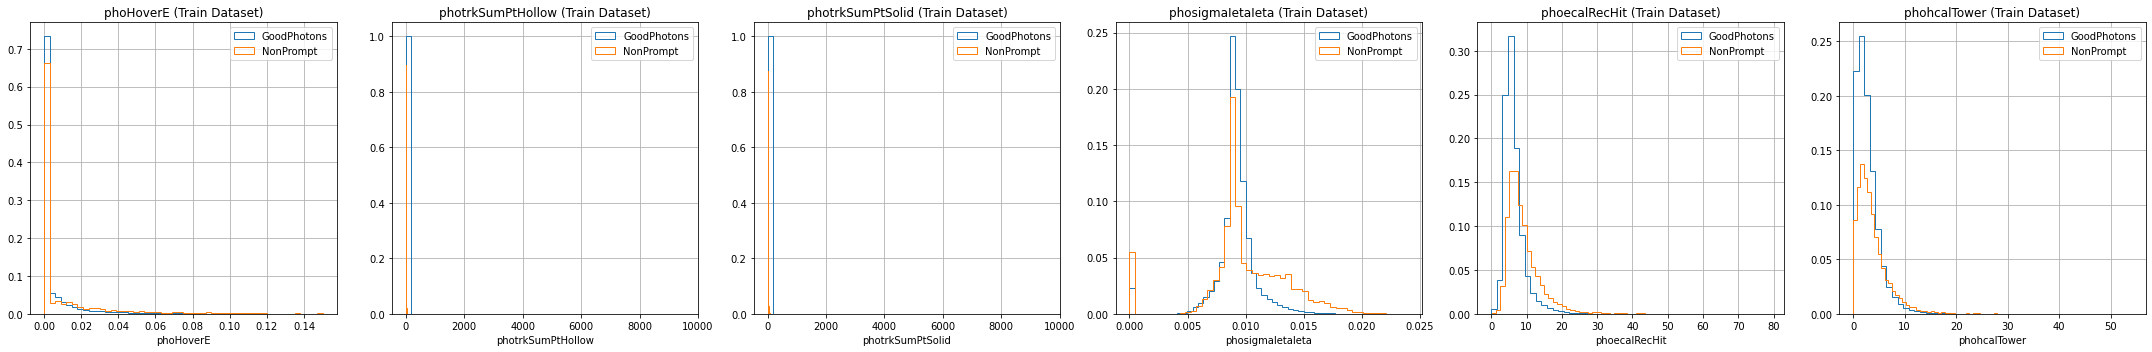

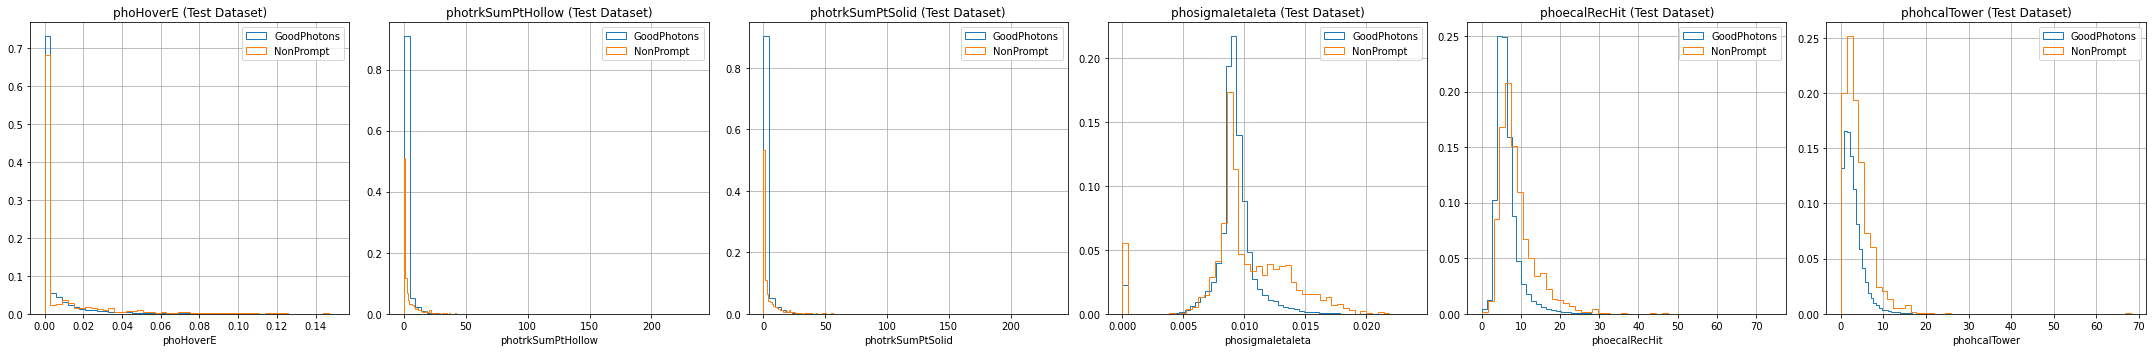

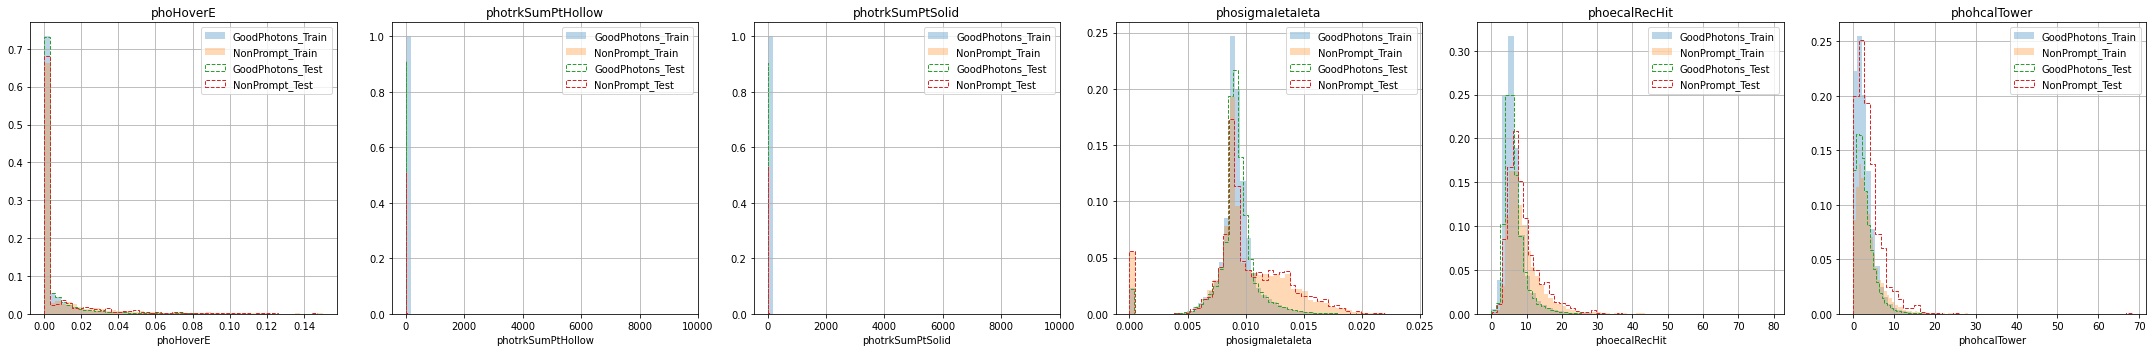

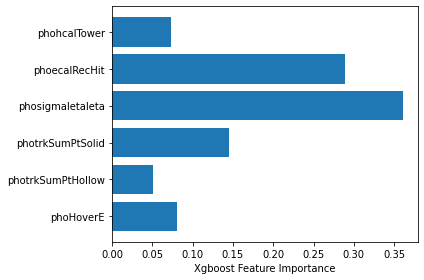

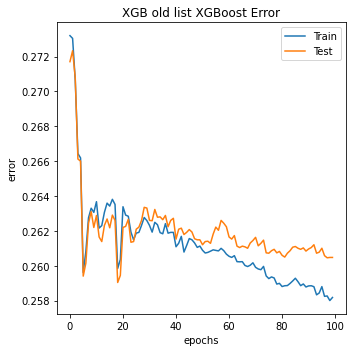

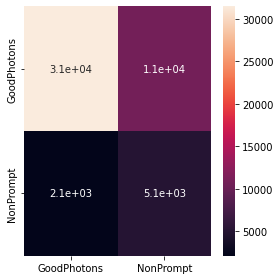

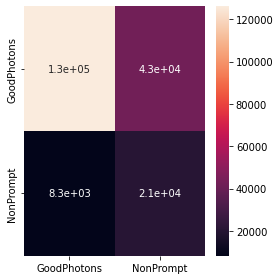

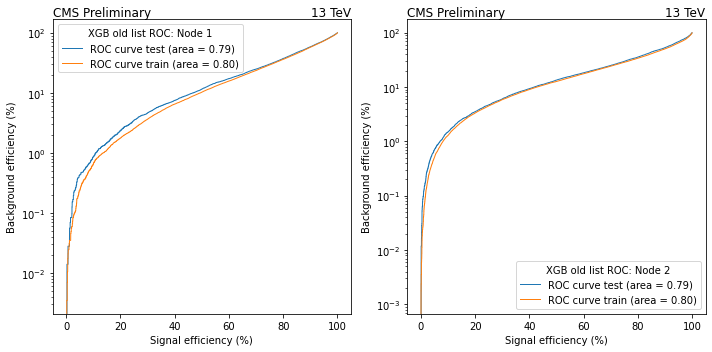

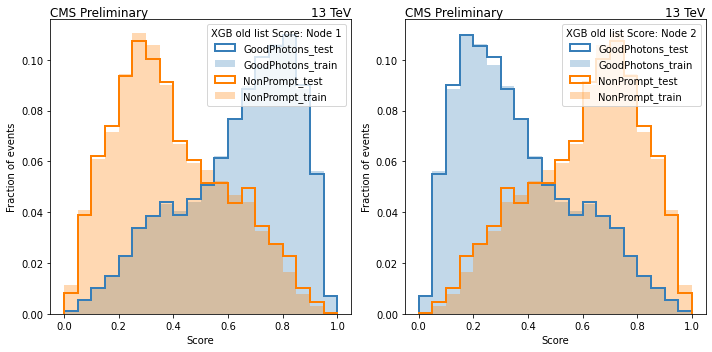

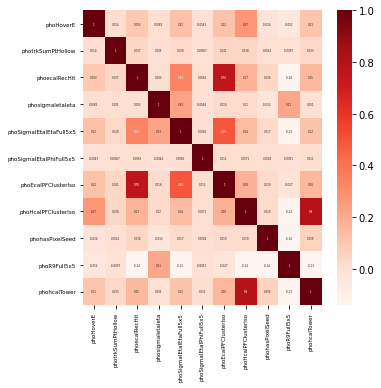

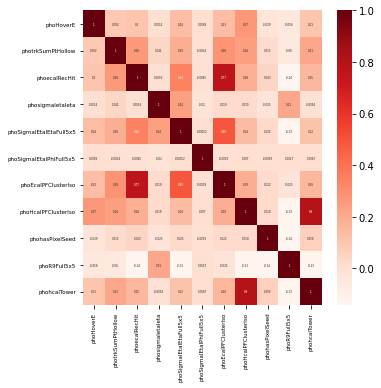

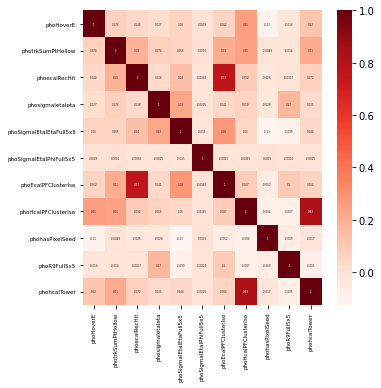

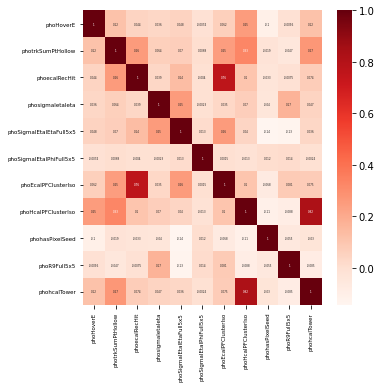

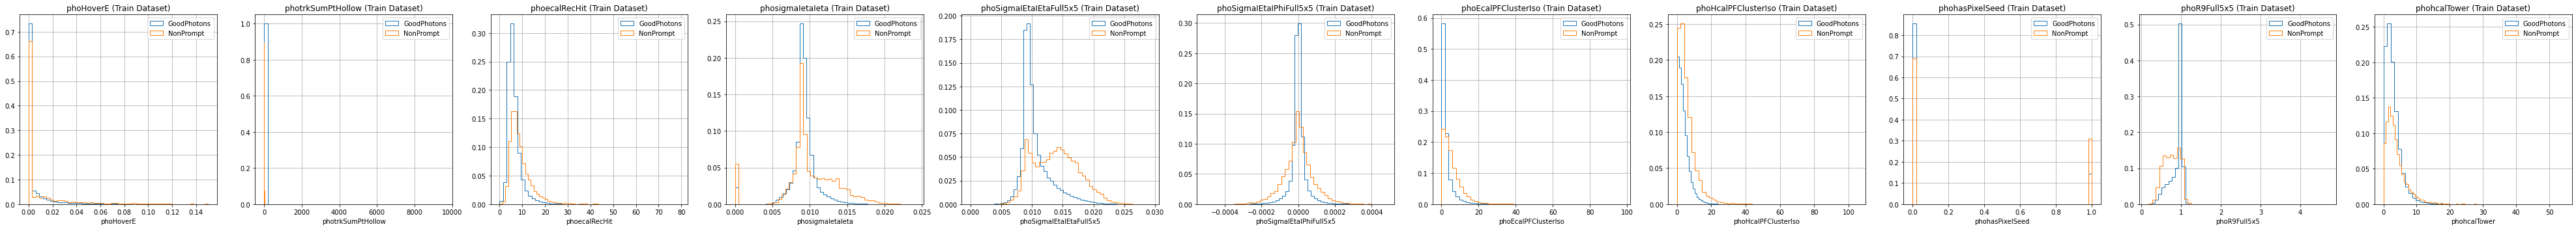

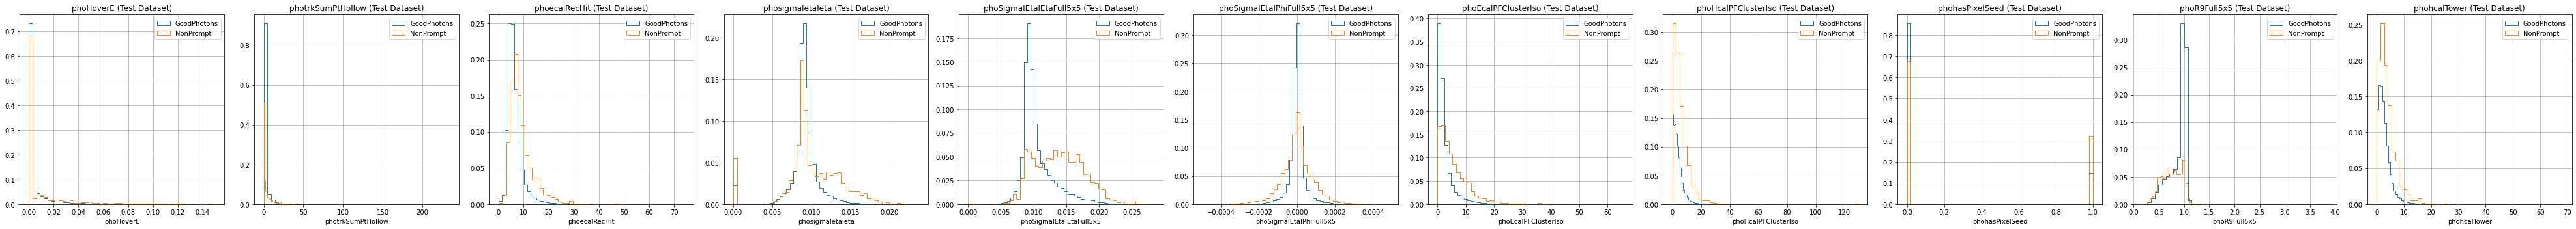

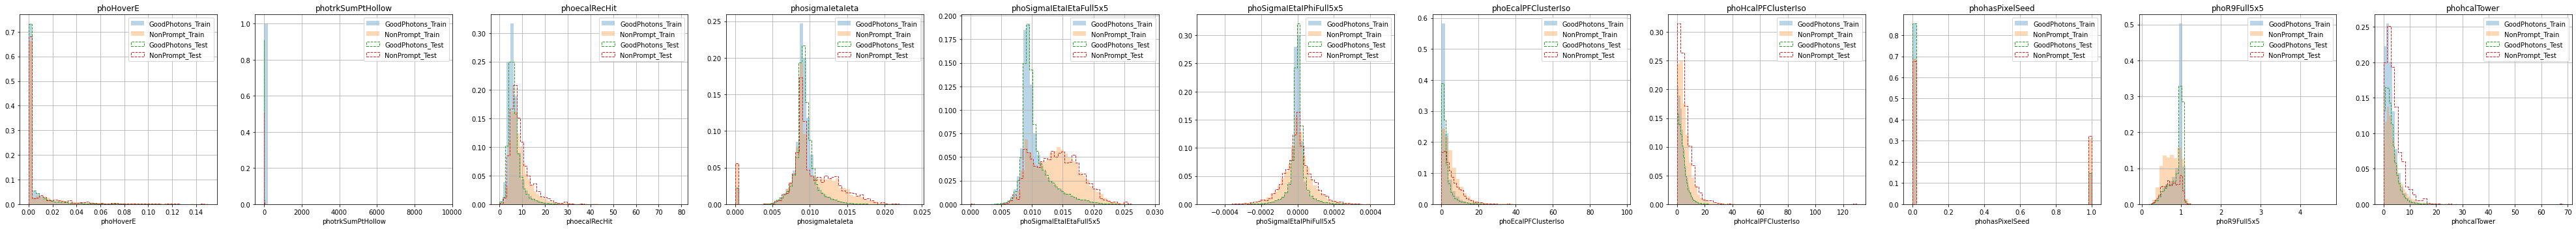

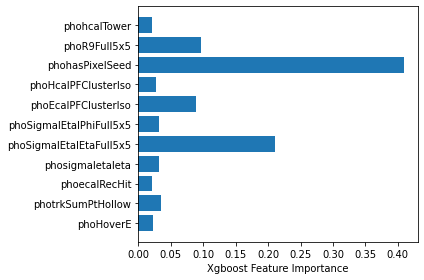

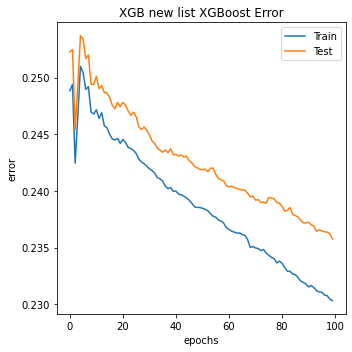

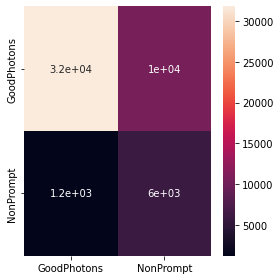

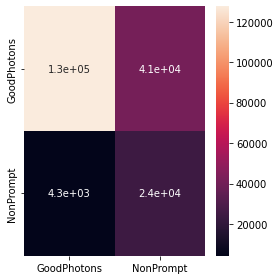

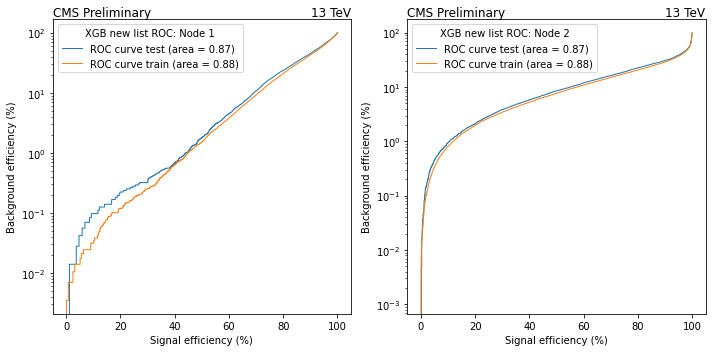

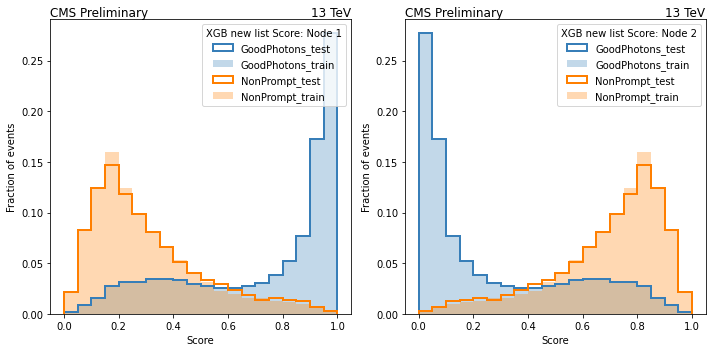

In [35]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
for MVA in Conf.MVAs:
    corre(df_final,Conf.Classes,MVA)
    MakeFeaturePlots(df_final,MVA["features"],MVA["feature_bins"],Set="Train",MVA=MVA["MVAtype"],OutputDirName=Conf.OutputDirName,label=Conf.Classes,log=Conf.MVAlogplot)
    MakeFeaturePlots(df_final,MVA["features"],MVA["feature_bins"],Set="Test",MVA=MVA["MVAtype"],OutputDirName=Conf.OutputDirName,label=Conf.Classes,log=Conf.MVAlogplot)
    MakeFeaturePlotsComb(df_final,MVA["features"],MVA["feature_bins"],MVA=MVA["MVAtype"],OutputDirName=Conf.OutputDirName,label=Conf.Classes,log=Conf.MVAlogplot)
    
    if 'XGB' in MVA["MVAtype"]:
        ###############XGB#######################################
        X_train, Y_train, Wt_train, X_test, Y_test, Wt_test = PrepDataset(df_final,TrainIndices,TestIndices,MVA["features"],cat,weight)
        prGreen(MVA["MVAtype"]+" Applying "+MVA["Scaler"])
        exec("from sklearn.preprocessing import "+MVA["Scaler"])
        exec("sc = "+MVA["Scaler"]+"()")
        X_train = sc.fit_transform(X_train)
        X_test = sc.transform(X_test)
        prGreen(MVA["MVAtype"]+" Training starting")
        import xgboost as xgb
        from sklearn.model_selection import cross_val_score, GridSearchCV
        eval_s = [(X_train, Y_train),(X_test,Y_test)]
        if "UseGPU" in MVA and MVA["UseGPU"]:
            xgb_model = xgb.XGBClassifier(objective="binary:logistic", tree_method= 'gpu_hist',random_state=Conf.RandomState)
        else:
            xgb_model = xgb.XGBClassifier(objective="binary:logistic",random_state=Conf.RandomState)
        prGreen("Performing XGB grid search")
        
        if Conf.Multicore:
            cv = GridSearchCV(xgb_model, MVA["XGBGridSearch"],
                              scoring='neg_log_loss',cv=3,verbose=1,n_jobs=multiprocessing.cpu_count())#multiprocessing.cpu_count())
        else:
            cv = GridSearchCV(xgb_model, MVA["XGBGridSearch"],
                              scoring='neg_log_loss',cv=3,verbose=1)
        search=cv.fit(X_train, Y_train, sample_weight=Wt_train,verbose=0,eval_set=eval_s)
        pickle.dump(cv, open(Conf.OutputDirName+"/"+MVA["MVAtype"]+"/"+MVA["MVAtype"]+"_"+"modelXGB.pkl", "wb"))
        prGreen("Expected neg log loss of XGB model = "+str((np.round(np.average(search.best_score_),3))*100)+'%')
        #prGreen("Expected accuracy of XGB model = "+str((np.average(search.best_score_))*100)+'%')
        prGreen("XGB Best Parameters")
        #json.dumps(search.best_params_)
        prGreen(str(search.best_params_))
        #sorted_idx = list(cv.best_estimator_.feature_importances_.argsort())
        #prGreen(sorted_idx)
        fig, ax = plt.subplots()
        ax.barh(MVA["features"],cv.best_estimator_.feature_importances_)
        ax.set_xlabel("Xgboost Feature Importance")
        fig.savefig(Conf.OutputDirName+"/"+MVA["MVAtype"]+"/"+MVA["MVAtype"]+"_"+"_Importance_.png")
        results = cv.best_estimator_.evals_result()
        if len(Conf.Classes)<3:
            epochs = len(results['validation_0']['error'])
        else:
            epochs = len(results['validation_0']['merror'])
        x_axis = range(0, epochs)
        fig, ax = plt.subplots(figsize=(5,5))
        if len(Conf.Classes)<3:
            ax.plot(x_axis, results['validation_0']['error'], label='Train')
            ax.plot(x_axis, results['validation_1']['error'], label='Test')
        else:
            ax.plot(x_axis, results['validation_0']['merror'], label='Train')
            ax.plot(x_axis, results['validation_1']['merror'], label='Test')
        ax.legend()
        ax.set_ylabel('error')
        ax.set_xlabel('epochs')
        ax.set_title(MVA["Label"]+' XGBoost Error')
        fig.savefig(Conf.OutputDirName+"/"+MVA["MVAtype"]+"/"+MVA["MVAtype"]+"_"+"_error_.png")
        print("All XGBoost parameters")
        print(cv.get_params())
        y_test_pred=cv.predict_proba(X_test)
        y_train_pred=cv.predict_proba(X_train)
        Y_train = to_categorical(Y_train, num_classes=len(Conf.Classes))
        Y_test = to_categorical(Y_test, num_classes=len(Conf.Classes))
        
        if len(Conf.Classes)<=2:
            df_final.loc[TrainIndices,MVA["MVAtype"]+"_pred"]=cv.predict_proba(X_train)[:,0]
            df_final.loc[TestIndices,MVA["MVAtype"]+"_pred"]=cv.predict_proba(X_test)[:,0]


        if len(Conf.Classes)>2:
            print("Only for threshold purposes: Assuming that first two classes are signal: To make any change, please change hardcoded discriminator")
            print("This does not affect the ROC or scores")
            df_final.loc[TrainIndices,MVA["MVAtype"]+"_pred"]=np.sum([cv.predict_proba(X_train)[:, 0],cv.predict_proba(X_train)[:, 1]],axis=0)
            df_final.loc[TestIndices,MVA["MVAtype"]+"_pred"]=np.sum([cv.predict_proba(X_test)[:, 0],cv.predict_proba(X_test)[:, 1]],axis=0)
        ###############XGB#######################################
        
        
    if 'Genetic' in MVA["MVAtype"]:
        ###############Genetic#######################################
        prGreen("Sorry Genetic algo not implemented yet! Coming Soon")
        ###############Genetic#######################################
       
    if 'DNN' in MVA["MVAtype"]:
        ###############DNN#######################################
        X_train, Y_train, Wt_train, X_test, Y_test, Wt_test = PrepDataset(df_final,TrainIndices,TestIndices,MVA["features"],cat,weight)
        Y_train = to_categorical(Y_train, num_classes=len(Conf.Classes))
        Y_test = to_categorical(Y_test, num_classes=len(Conf.Classes))
        print(Y_train.shape)
        prGreen(MVA["MVAtype"]+" Applying "+MVA["Scaler"])
        exec("from sklearn.preprocessing import "+MVA["Scaler"])
        exec("sc = "+MVA["Scaler"]+"()")
        X_train = sc.fit_transform(X_train)
        X_test = sc.transform(X_test)
        prGreen("DNN fitting running")
        try:
            es = MVA["DNNDict"]['earlyStopping']
            print("Setting early stopping")
        except KeyError:
            es=EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
            print("No early stopping specified, will use the default one")
        #es = MVA["DNNDict"]['earlyStopping']
        modelDNN=MVA["DNNDict"]['model']
        modelDNN.compile(loss=MVA["DNNDict"]['compile']['loss'], optimizer=MVA["DNNDict"]['compile']['optimizer'], metrics=MVA["DNNDict"]['compile']['metrics'])
        train_history = modelDNN.fit(X_train,Y_train,epochs=MVA["DNNDict"]['epochs'],batch_size=MVA["DNNDict"]['batchsize'],validation_data=(X_test,Y_test, Wt_test),
                                     verbose=1,callbacks=[es], sample_weight=Wt_train)
        modelDNN.save(Conf.OutputDirName+"/"+MVA["MVAtype"]+"/"+MVA["MVAtype"]+"_"+"modelDNN.h5")
        
        training_loss = train_history.history['loss']
        test_loss = train_history.history['val_loss']

        # Create count of the number of epochs
        epoch_count = range(1, len(training_loss) + 1)

        # Visualize loss history
        fig, axes = plt.subplots(1, 1, figsize=(5, 5))
        axes.plot(epoch_count, training_loss)
        axes.plot(epoch_count, test_loss)
        axes.legend(['Training Loss', 'Test Loss'])
        axes.set_xlabel('Epoch')
        axes.set_ylabel(MVA["Label"]+': Loss')
        plt.savefig(Conf.OutputDirName+"/"+MVA["MVAtype"]+"/"+MVA["MVAtype"]+"_"+"Loss.pdf")
        plt.savefig(Conf.OutputDirName+"/"+MVA["MVAtype"]+"/"+MVA["MVAtype"]+"_"+"Loss.png")
        
        y_train_pred=np.array(modelDNN.predict(X_train,batch_size=5000)) #This is not the training batch size
        y_test_pred=np.array(modelDNN.predict(X_test,batch_size=5000)) #This is not the training batch size
        #https://anshulhep.medium.com/make-your-tensorflow-keras-predictions-faster-with-batch-size-8bbd780b9c08
        
        if len(Conf.Classes)<=2:
            df_final.loc[TrainIndices,MVA["MVAtype"]+"_pred"]=modelDNN.predict(X_train,batch_size=5000)[:,0]
            df_final.loc[TestIndices,MVA["MVAtype"]+"_pred"]=modelDNN.predict(X_test,batch_size=5000)[:,0]


        if len(Conf.Classes)>2:
            print("Only for threshold purposes: Assuming that first two classes are signal: To make any change, please change hardcoded discriminator")
            print("This does not affect the ROC or scores")
            df_final.loc[TrainIndices,MVA["MVAtype"]+"_pred"]=np.sum([modelDNN.predict(X_train,batch_size=5000)[:, 0],modelDNN.predict(X_train,batch_size=5000)[:, 1]],axis=0)
            df_final.loc[TestIndices,MVA["MVAtype"]+"_pred"]=np.sum([modelDNN.predict(X_test,batch_size=5000)[:, 0],modelDNN.predict(X_test,batch_size=5000)[:, 1]],axis=0)
            
        ###############DNN#######################################
        
    plotwt_train=np.asarray(df_final.loc[TrainIndices,'xsecwt'])
    plotwt_test=np.asarray(df_final.loc[TestIndices,'xsecwt'])
    
    from sklearn.metrics import confusion_matrix
    fig, axes = plt.subplots(1, 1, figsize=(len(Conf.Classes)*2, len(Conf.Classes)*2))
    cm = confusion_matrix(Y_test.argmax(axis=1), y_test_pred.argmax(axis=1))
    cm_df = pd.DataFrame(cm,index = Conf.Classes, columns = Conf.Classes)
    sns.heatmap(cm_df, annot=True,ax=axes)
    axes.set_yticklabels(axes.get_yticklabels(), va='center')
    axes.set_xticklabels(axes.get_yticklabels(), ha='center')
    fig.savefig(Conf.OutputDirName+"/"+MVA["MVAtype"]+"/"+MVA["MVAtype"]+"_"+"CM_Testing.png")
    
    fig, axes = plt.subplots(1, 1, figsize=(len(Conf.Classes)*2, len(Conf.Classes)*2))
    cm = confusion_matrix(Y_train.argmax(axis=1), y_train_pred.argmax(axis=1))
    cm_df = pd.DataFrame(cm,index = Conf.Classes,columns = Conf.Classes)
    sns.heatmap(cm_df, annot=True,ax=axes)
    axes.set_yticklabels(axes.get_yticklabels(), va='center')
    axes.set_xticklabels(axes.get_yticklabels(), ha='center')
    fig.savefig(Conf.OutputDirName+"/"+MVA["MVAtype"]+"/"+MVA["MVAtype"]+"_"+"CM_Training.png") 
    
    from sklearn.metrics import roc_curve, auc

    n_classes=len(Conf.Classes)
    
    fig, axes = plt.subplots(1, n_classes, figsize=(n_classes*5, 5))
    figMVA, axesMVA = plt.subplots(1, n_classes, figsize=(n_classes*5, 5))    
    for i in range(n_classes):
            axMVA=axesMVA[i]
            ax=axes[i]
            for k in range(n_classes):
                axMVA.hist(y_test_pred[:, i][Y_test[:, k]==1],bins=np.linspace(0, 1, 21),label=Conf.Classes[k]+'_test',
                           weights=plotwt_test[Y_test[:, k]==1]/np.sum(plotwt_test[Y_test[:, k]==1]),
                           histtype='step',linewidth=2,color=Conf.ClassColors[k])
                axMVA.hist(y_train_pred[:, i][Y_train[:, k]==1],bins=np.linspace(0, 1, 21),label=Conf.Classes[k]+'_train',
                           weights=plotwt_train[Y_train[:, k]==1]/np.sum(plotwt_train[Y_train[:, k]==1]),
                           histtype='stepfilled',alpha=0.3,linewidth=2,color=Conf.ClassColors[k])
            #axMVA.set_title(MVA["Label"]+' Score: Node '+str(i+1),fontsize=10)
            axMVA.set_xlabel('Score',fontsize=10)
            #axMVA.set_ylim(0,1.3)
            axMVA.set_ylabel('Fraction of events',fontsize=10)
            axMVA.legend(title=MVA["Label"]+' Score: Node '+str(i+1), loc="best",fontsize=10)
            axMVA.text(0, 1, str(Conf.CMSLabel[0]), horizontalalignment = 'left', verticalalignment = 'bottom', transform=axMVA.transAxes, fontsize = 12)#, fontweight = 'bold')
            #ax.text(0.14, 1, "$\it{Simulation}$", horizontalalignment = 'left', verticalalignment = 'bottom', transform = ax.transAxes, fontsize = 13)
            axMVA.text(1, 1, Conf.CMSLabel[1], horizontalalignment = 'right', verticalalignment = 'bottom', transform = axMVA.transAxes, fontsize = 12)
            if Conf.MVAlogplot:
                axMVA.set_yscale('log')

            fpr, tpr, th = roc_curve(Y_test[:, i], y_test_pred[:, i],sample_weight=plotwt_test)
            fpr_tr, tpr_tr, th_tr = roc_curve(Y_train[:, i], y_train_pred[:, i],sample_weight=plotwt_train)
            mask = tpr > 0.0
            fpr, tpr = fpr[mask], tpr[mask]

            mask = tpr_tr > 0.0
            fpr_tr, tpr_tr = fpr_tr[mask], tpr_tr[mask]

            roc_auc = auc(fpr, tpr)
            roc_auc_tr = auc(fpr_tr, tpr_tr)
            
            ax.plot(tpr*100, fpr*100, label='ROC curve test (area = %0.2f)' % roc_auc,linewidth=1)
            ax.plot(tpr_tr*100, fpr_tr*100, label='ROC curve train (area = %0.2f)' % roc_auc_tr,linewidth=1)
            ax.text(0, 1, str(Conf.CMSLabel[0]), horizontalalignment = 'left', verticalalignment = 'bottom', transform=ax.transAxes, fontsize = 12)#, fontweight = 'bold')
            #ax.text(0.14, 1, "$\it{Simulation}$", horizontalalignment = 'left', verticalalignment = 'bottom', transform = ax.transAxes, fontsize = 13)
            ax.text(1, 1, Conf.CMSLabel[1], horizontalalignment = 'right', verticalalignment = 'bottom', transform = ax.transAxes, fontsize = 12)
            if Conf.ROClogplot: ax.set_yscale("log")
            #plt.plot([0, 1], [0, 1], 'k--')
            #ax.set_xlim([0.8, 1.0])
            #ax.set_ylim([0.0, 1.05])
            ax.set_xlabel('Signal efficiency (%)',fontsize=10)
            ax.set_ylabel('Background efficiency (%)',fontsize=10)
            #ax.set_title(MVA["Label"]+' ROC: Node '+str(i+1),fontsize=10)
            ax.legend(title=MVA["Label"]+' ROC: Node '+str(i+1),loc="best",fontsize=10)
    fig.savefig(Conf.OutputDirName+"/"+MVA["MVAtype"]+"/"+MVA["MVAtype"]+"_"+"ROC.pdf")
    fig.savefig(Conf.OutputDirName+"/"+MVA["MVAtype"]+"/"+MVA["MVAtype"]+"_"+"ROC.png")
    figMVA.savefig(Conf.OutputDirName+"/"+MVA["MVAtype"]+"/"+MVA["MVAtype"]+"_"+"MVA.pdf")
    figMVA.savefig(Conf.OutputDirName+"/"+MVA["MVAtype"]+"/"+MVA["MVAtype"]+"_"+"MVA.png")
        
        

 Plotting Final ROC


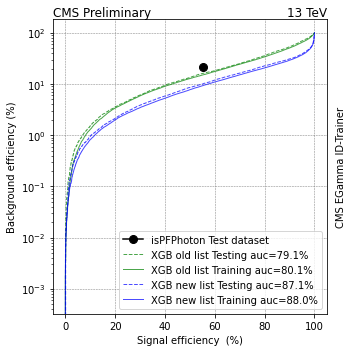

In [29]:
if len(Conf.Classes)<=2:
    prGreen("Plotting Final ROC")
    fig, axes = plt.subplots(1, 1, figsize=(5, 5))
    if hasattr(Conf, 'OverlayWP') and len(Conf.OverlayWP)>0:
        for color,OverlayWpi in zip(Conf.OverlayWPColors,Conf.OverlayWP):
            
            plot_single_roc_point(df_final.query('TrainDataset==0'), var=OverlayWpi, ax=axes, color=color, marker='o', markersize=8, label=OverlayWpi+" Test dataset", cat=cat,Wt=weight)
    if len(Conf.MVAs)>0:
        for MVAi in Conf.MVAs:
            plot_roc_curve(df_final.query('TrainDataset==0'),MVAi["MVAtype"]+"_pred", tpr_threshold=0.0, ax=axes, color=MVAi["Color"], linestyle='--', label=MVAi["Label"]+' Testing',cat=cat,Wt='xsecwt')
            plot_roc_curve(df_final.query('TrainDataset==1'),MVAi["MVAtype"]+"_pred", tpr_threshold=0.0, ax=axes, color=MVAi["Color"], linestyle='-', label=MVAi["Label"]+' Training',cat=cat,Wt='xsecwt')
        axes.set_ylabel("Background efficiency (%)")
        axes.set_xlabel("Signal efficiency  (%)")
        axes.text(0, 1, str(Conf.CMSLabel[0]), horizontalalignment = 'left', verticalalignment = 'bottom', transform=axes.transAxes, fontsize = 12)#, fontweight = 'bold')
        #ax.text(0.14, 1, "$\it{Simulation}$", horizontalalignment = 'left', verticalalignment = 'bottom', transform = ax.transAxes, fontsize = 13)
        axes.text(1, 1, Conf.CMSLabel[1], horizontalalignment = 'right', verticalalignment = 'bottom', transform = axes.transAxes, fontsize = 12)
        axes.text(1.05, 0.5, 'CMS EGamma ID-Trainer',
                  horizontalalignment='center',
                  verticalalignment='center',
                  rotation='vertical',
                  transform=axes.transAxes)
        axes.grid(color='gray', linestyle='--', linewidth=0.5)
        if Conf.ROClogplot:
            axes.set_yscale("log")
    fig.savefig(Conf.OutputDirName+"/ROCFinal.pdf")
    fig.savefig(Conf.OutputDirName+"/ROCFinal.png")

In [30]:
def eff(group_df,var,cat,catvalue):
    signalpass=len(group_df.query('('+var+' == 1) & ('+cat+' == '+str(catvalue)+')'))
    signalpass=ufloat(signalpass,math.sqrt(signalpass))
    signaltotal=len(group_df.query('('+cat+' == '+str(catvalue)+')'))
    signaltoal=ufloat(signaltotal,math.sqrt(signaltotal))
    if signaltotal>0:
        signaleff=(100*signalpass)/(signaltotal)
        return [signaleff.n, signaleff.s]
    else:
        print("Some bins have zero signal: assigning zero eff")
        return [0, 0]

def EffTrend(cat='',var='',groupbyvar='',ptbins=[],label='',title='',plotname='',df=pd.DataFrame(),plot_dir='',Classes=[''],Colors=['']):
    figMVAComp, axesComp = plt.subplots(1,1, figsize=(6, 6))
    ax=axesComp
    fulllist=[[] for i in range(len(Classes))]
    fullliste=[[[] for i in range(2)] for i in range(len(Classes))]
    #ptbinsmy=ptbins[:-1]
    ptbinsmy=[(ptbins[m+1]+ptbins[m])/2 for m in range(len(ptbins)-1)]
    if groupbyvar=='ele_pt_bin':
        ptbinsmy[len(ptbinsmy)-1]=ptbins[len(ptbins)-2]*1.2
    #ptbinsmy.append(ptbins[len(ptbins)-1]*1.2)
    xefulllist=[(ptbins[m+1]-ptbins[m])/2 for m in range(len(ptbins)-1)]
    if groupbyvar=='ele_pt_bin':
        xefulllist[len(ptbinsmy)-1]=ptbins[len(ptbins)-2]*0.2
    for i,group_df in df.groupby(groupbyvar):
        for k in range(len(Classes)):
            val=eff(group_df,var,cat,k)[0]
            vale=eff(group_df,var,cat,k)[1]
            fulllist[k].append(val)
            fullliste[k][0].append(vale)
            if val+vale<100:
                fullliste[k][1].append(vale)
            else:
                fullliste[k][1].append(100-val)
                
        
    for m in range(len(Classes)):
        if len(Classes)>2:
            if m==0 or m==1:
                marker='S'
            else:
                marker='B'
        if len(Classes)<3:
            if m==0:
                marker='S'
            else:
                marker='B'
        ax.errorbar(ptbinsmy,fulllist[m],xerr=xefulllist,yerr=fullliste[m],markersize=6,markeredgecolor='black',label=Classes[m],color=Colors[m],fmt = '.')
    ax.set_ylim(0,130)
    if groupbyvar=='ele_pt_bin':
        #ax.set_yscale('log')
        ax.set_xlim(ptbins[0],ptbins[len(ptbins)-2]*1.4)
    #if groupbyvar=='ele_eta_bin':
        #ax.set_xlim(ptbins[0]*1.2,ptbins[len(ptbins)-1])
    ax.set_xlabel(label)
    ax.set_ylabel("Efficiency (%)")
    ax.set_title(title)
    ax.grid(True)
    #ax.legend(loc='best',ncol=2,bbox_to_anchor=(0., 1.1, 1., 0.2),fontsize=8)
    ax.legend(loc='best',ncol=2,fontsize=10)
    figMVAComp.savefig(plot_dir+plotname+".pdf")
    figMVAComp.savefig(plot_dir+plotname+".png")

Assuming that first class is signal: To make any change, please change hardcoded discriminator
This does not affect the ROC or scores


<ipython-input-30-1db9250783af>:49: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  ax.errorbar(ptbinsmy,fulllist[m],xerr=xefulllist,yerr=fullliste[m],markersize=6,marker=marker,markeredgecolor='black',label=Classes[m],color=Colors[m],fmt = '.')
<ipython-input-30-1db9250783af>:49: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  ax.errorbar(ptbinsmy,fulllist[m],xerr=xefulllist,yerr=fullliste[m],markersize=6,marker=marker,markeredgecolor='black',label=Classes[m],color=Colors[m],fmt = '.')
<ipython-input-30-1db9250783af>:49: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  ax.errorbar(ptbinsmy,fulllist[m],xerr=xefulllist,yerr=fullliste[m],markersize=6,marke

Assuming that first class is signal: To make any change, please change hardcoded discriminator
This does not affect the ROC or scores


<ipython-input-30-1db9250783af>:49: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  ax.errorbar(ptbinsmy,fulllist[m],xerr=xefulllist,yerr=fullliste[m],markersize=6,marker=marker,markeredgecolor='black',label=Classes[m],color=Colors[m],fmt = '.')
<ipython-input-30-1db9250783af>:49: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  ax.errorbar(ptbinsmy,fulllist[m],xerr=xefulllist,yerr=fullliste[m],markersize=6,marker=marker,markeredgecolor='black',label=Classes[m],color=Colors[m],fmt = '.')
<ipython-input-30-1db9250783af>:49: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  ax.errorbar(ptbinsmy,fulllist[m],xerr=xefulllist,yerr=fullliste[m],markersize=6,marke

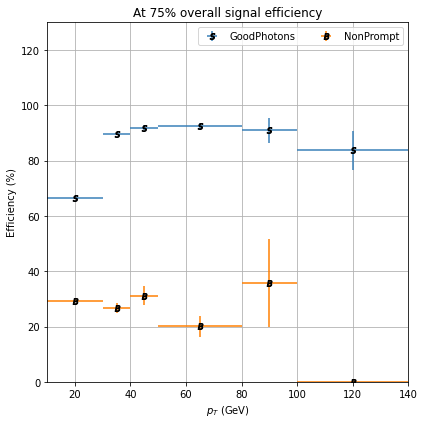

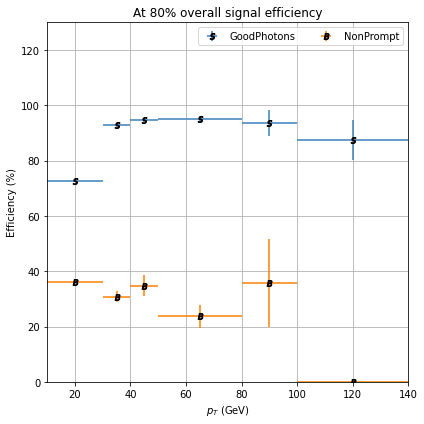

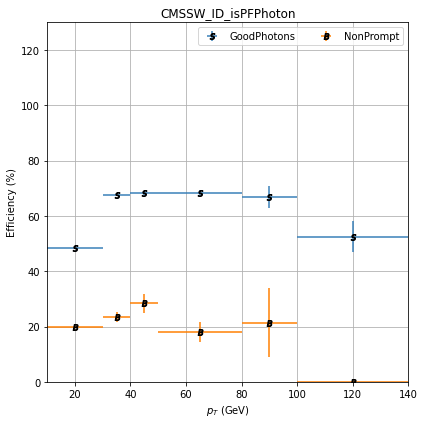

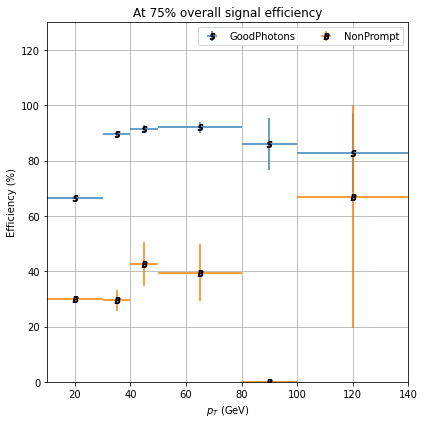

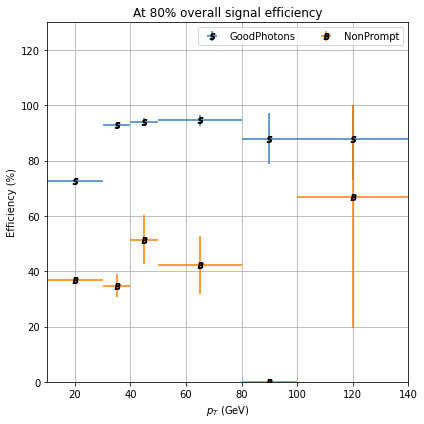

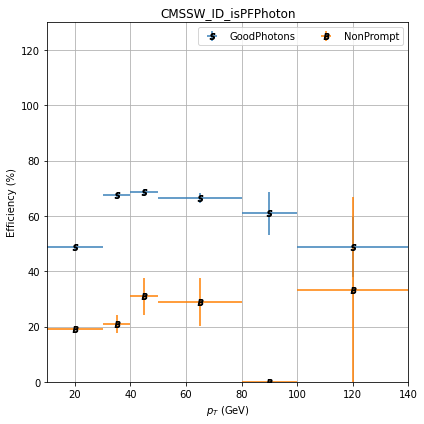

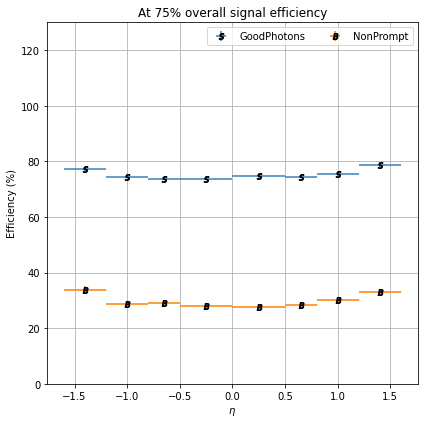

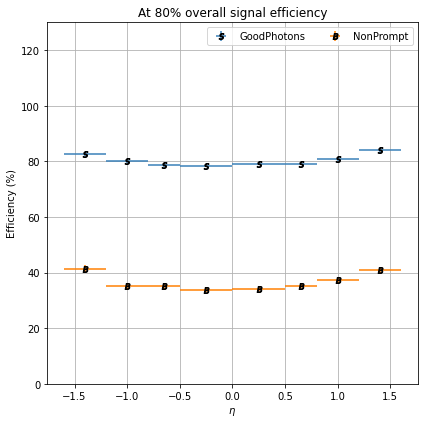

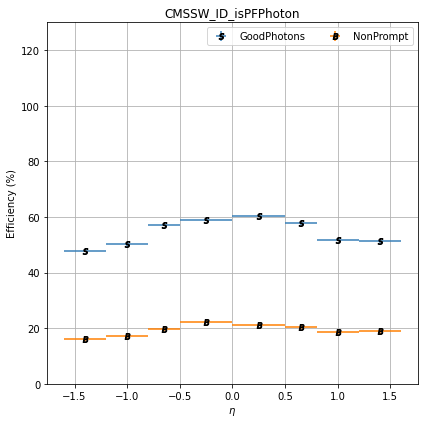

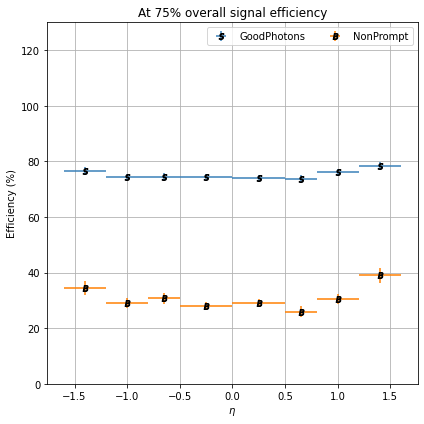

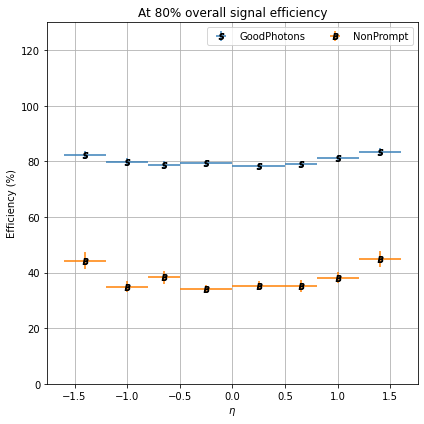

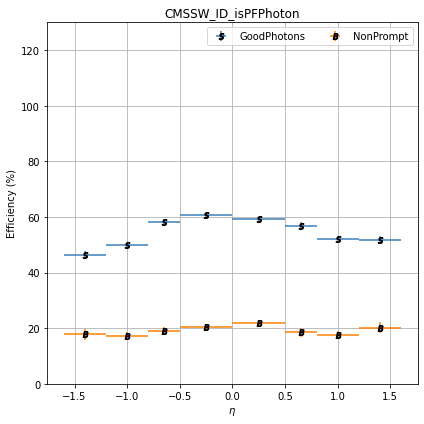

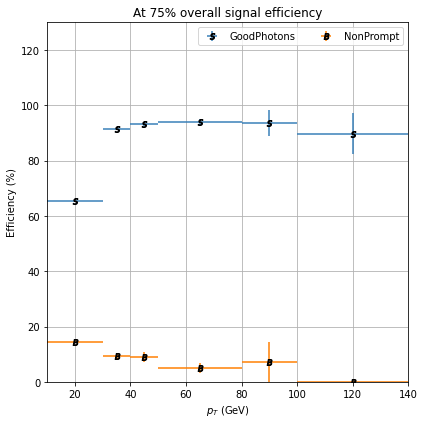

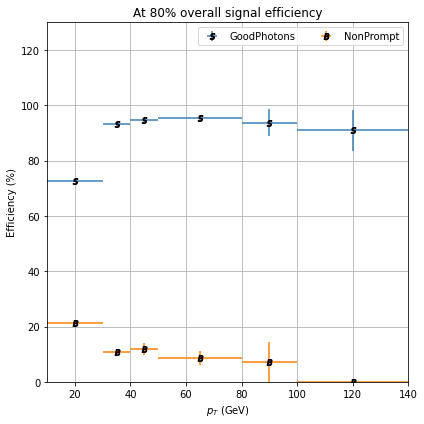

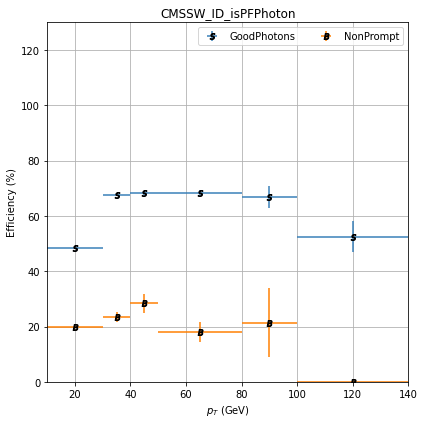

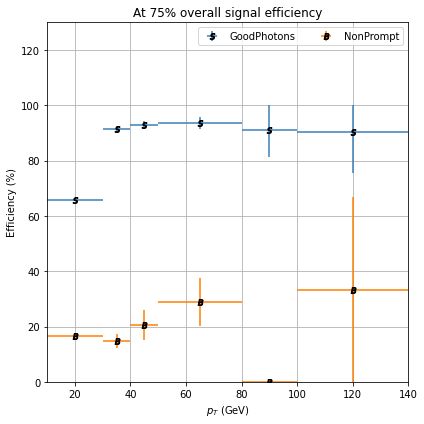

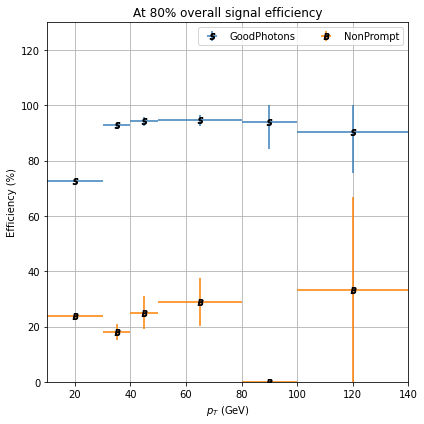

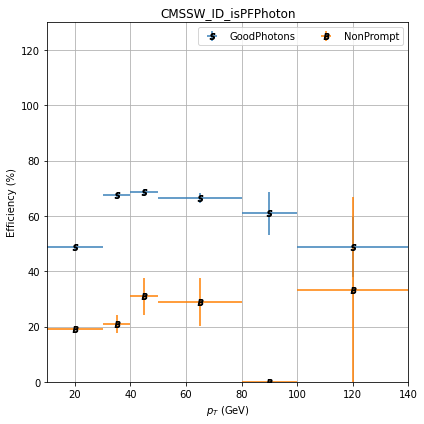

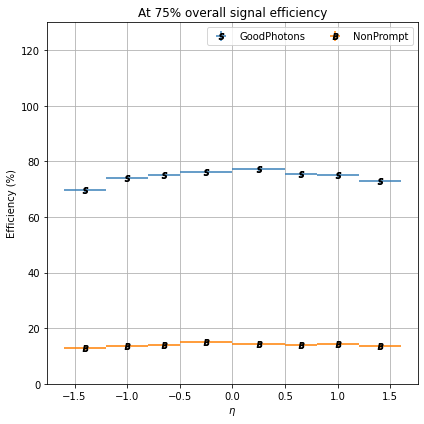

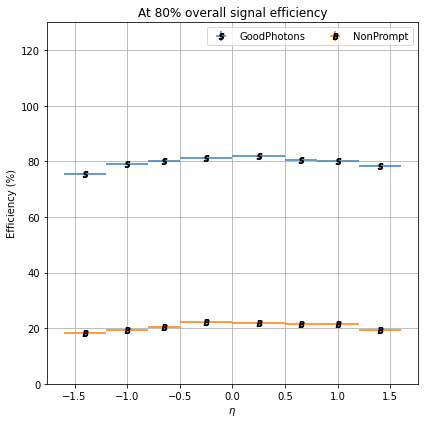

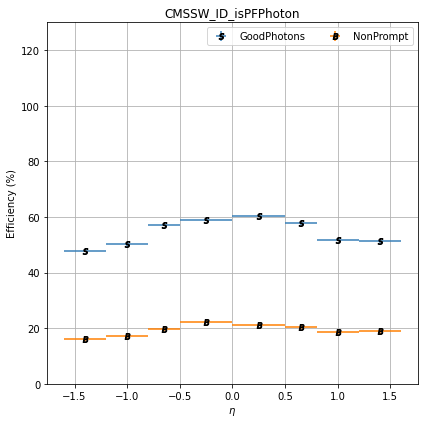

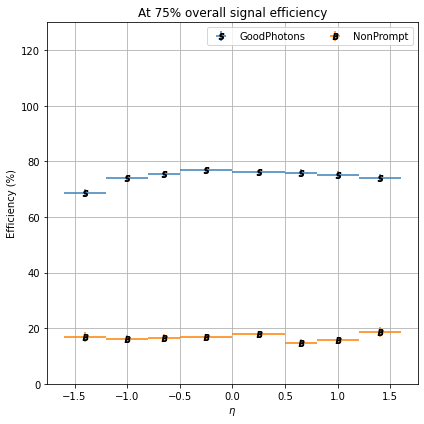

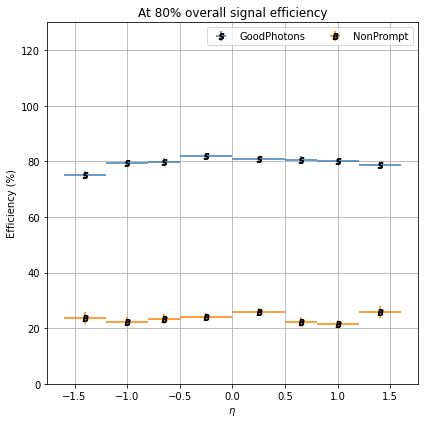

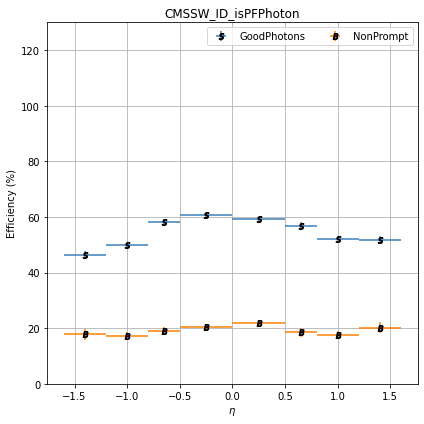

In [31]:
if hasattr(Conf, 'SigEffWPs')and len(Conf.SigEffWPs)>0:
    PredMVAs=[]
    for MVA in Conf.MVAs:
        PredMVAs.append(MVA["MVAtype"]+'_pred')
    SigEffWPs=Conf.SigEffWPs[:]
    for i,SigEffWPi in enumerate(SigEffWPs):
        SigEffWPs[i]=1-(int(SigEffWPi.replace('%', ''))/100)
    

    for MVA in Conf.MVAs:

        df_final["ele_pt_bin"] = pd.cut(df_final[Conf.ptwtvar], bins=Conf.ptbins, labels=list(range(len(Conf.ptbins)-1)))
        df_final["ele_eta_bin"] = pd.cut(df_final[Conf.etawtvar], bins=Conf.etabins, labels=list(range(len(Conf.etabins)-1)))

        EB_train=df_final.loc[TrainIndices]
        EB_test=df_final.loc[TestIndices]
        
        if len(Conf.Classes) > 2:
            print("Assuming that first two classes are signal: To make any change, please change hardcoded discriminator")
            print("This does not affect the ROC or scores")
            mydftrain=EB_train.query(cat+"==1 | "+cat+"==0")[[MVA["MVAtype"]+"_pred"]].quantile(SigEffWPs)
            mydftest=EB_test.query(cat+"==1 | "+cat+"==0")[[MVA["MVAtype"]+"_pred"]].quantile(SigEffWPs)
            
            #figMVA, axesMVA = plt.subplots(1, n_classes, figsize=(5, 5))
            #plot_mva(EB_train, MVA["MVAtype"]+"_pred", 100, logscale=False, ax=axMVA, title="Combined Score", ls='dashed', alpha=0.5, sample='Train',cat="Class",Wt="Wt",Classes=Conf.Classes,Colors=Conf.ClassColors)
            
        if len(Conf.Classes) < 3:
            print("Assuming that first class is signal: To make any change, please change hardcoded discriminator")
            print("This does not affect the ROC or scores")
            mydftrain=EB_train.query(cat+"==0")[[MVA["MVAtype"]+"_pred"]].quantile(SigEffWPs)
            mydftest=EB_test.query(cat+"==0")[[MVA["MVAtype"]+"_pred"]].quantile(SigEffWPs)
            
        EB_train.loc[EB_train[MVA["MVAtype"]+"_pred"] > mydftrain.iat[0,0], MVA["MVAtype"]+"_predpass"] = 1
        EB_train.loc[EB_train[MVA["MVAtype"]+"_pred"] < mydftrain.iat[0,0], MVA["MVAtype"]+"_predpass"] = 0

        EB_train.loc[EB_train[MVA["MVAtype"]+"_pred"] > mydftrain.iat[1,0], MVA["MVAtype"]+"_predpass1"] = 1
        EB_train.loc[EB_train[MVA["MVAtype"]+"_pred"] < mydftrain.iat[1,0], MVA["MVAtype"]+"_predpass1"] = 0

        EB_test.loc[EB_test[MVA["MVAtype"]+"_pred"] > mydftest.iat[0,0], MVA["MVAtype"]+"_predpass"] = 1
        EB_test.loc[EB_test[MVA["MVAtype"]+"_pred"] < mydftest.iat[0,0], MVA["MVAtype"]+"_predpass"] = 0

        EB_test.loc[EB_test[MVA["MVAtype"]+"_pred"] > mydftest.iat[1,0], MVA["MVAtype"]+"_predpass1"] = 1
        EB_test.loc[EB_test[MVA["MVAtype"]+"_pred"] < mydftest.iat[1,0], MVA["MVAtype"]+"_predpass1"] = 0

        variables=['ele_pt_bin','ele_eta_bin']
        bins=[Conf.ptbins,Conf.etabins]
        xaxislabels=['$p_T$ (GeV)','$\eta$']
        Wps=Conf.OverlayWP

        for variable,xaxislabel,binn in zip(variables,xaxislabels,bins):
            EffTrend(cat=cat,var=MVA["MVAtype"]+"_predpass",groupbyvar=variable,ptbins=binn,label=xaxislabel,title=f"At {Conf.SigEffWPs[0]} overall signal efficiency",plotname="New_MultiClass_ID_Val_"+Conf.SigEffWPs[0]+"_"+variable,df=EB_train,plot_dir=Conf.OutputDirName+"/"+MVA["MVAtype"]+"/Train_",Classes=Conf.Classes,Colors=Conf.ClassColors)
            EffTrend(cat=cat,var=MVA["MVAtype"]+"_predpass1",groupbyvar=variable,ptbins=binn,label=xaxislabel,title=f"At {Conf.SigEffWPs[1]} overall signal efficiency",plotname="New_MultiClass_ID_Val_"+Conf.SigEffWPs[1]+"_"+variable,df=EB_train,plot_dir=Conf.OutputDirName+"/"+MVA["MVAtype"]+"/Train_",Classes=Conf.Classes,Colors=Conf.ClassColors)
            for Wp in Wps:
                EffTrend(cat=cat,var=Wp,groupbyvar=variable,ptbins=binn, label=xaxislabel,title='CMSSW_ID_'+Wp,plotname="CMSSW_ID_"+Wp+"_"+variable,df=EB_train,plot_dir=Conf.OutputDirName+"/"+MVA["MVAtype"]+"/Train_",Classes=Conf.Classes,Colors=Conf.ClassColors)


            EffTrend(cat=cat,var=MVA["MVAtype"]+"_predpass",groupbyvar=variable,ptbins=binn,label=xaxislabel,title=f"At {Conf.SigEffWPs[0]} overall signal efficiency",plotname="New_MultiClass_ID_Val_"+Conf.SigEffWPs[0]+"_"+variable,df=EB_test,plot_dir=Conf.OutputDirName+"/"+MVA["MVAtype"]+"/Test_",Classes=Conf.Classes,Colors=Conf.ClassColors)
            EffTrend(cat=cat,var=MVA["MVAtype"]+"_predpass1",groupbyvar=variable,ptbins=binn,label=xaxislabel,title=f"At {Conf.SigEffWPs[1]} overall signal efficiency",plotname="New_MultiClass_ID_Val_"+Conf.SigEffWPs[1]+"_"+variable,df=EB_test,plot_dir=Conf.OutputDirName+"/"+MVA["MVAtype"]+"/Test_",Classes=Conf.Classes,Colors=Conf.ClassColors)
            for Wp in Wps:
                EffTrend(cat=cat,var=Wp,groupbyvar=variable,ptbins=binn, label=xaxislabel,title='CMSSW_ID_'+Wp,plotname="CMSSW_ID_"+Wp+"_"+variable,df=EB_test,plot_dir=Conf.OutputDirName+"/"+MVA["MVAtype"]+"/Test_",Classes=Conf.Classes,Colors=Conf.ClassColors)

In [32]:
if hasattr(Conf, 'SigEffWPs')and len(Conf.SigEffWPs)>0:
    prGreen("Threshold values for requested Signal Efficiencies (Train Dataset)")
    if len(Conf.Classes)>2:
        mydf=df_final.query("TrainDataset==1 & ("+cat+"==1 | "+cat+"==0"+")")[PredMVAs].quantile(SigEffWPs)
    if len(Conf.Classes)<=2:
        mydf=df_final.query("TrainDataset==1 & "+cat+"==0")[PredMVAs].quantile(SigEffWPs)
    mydf.insert(0, "WPs", Conf.SigEffWPs, True)
    mydf.set_index("WPs",inplace=True)
    prGreen(mydf)
    mydf.to_html(Conf.OutputDirName+'/Thresholds/'+"SigEffWPs_Train.html")
    mydf.to_csv(Conf.OutputDirName+'/Thresholds/'+"SigEffWPs_Train.csv")
    prGreen("Threshold values for requested Signal Efficiencies (Test Dataset)")
    if len(Conf.Classes)>2:
        mydf2=df_final.query("TrainDataset==0 & ("+cat+"==1 | "+cat+"==0"+")")[PredMVAs].quantile(SigEffWPs)
    if len(Conf.Classes)<=2:
        mydf2=df_final.query("TrainDataset==0 & "+cat+"==0")[PredMVAs].quantile(SigEffWPs)
    mydf2.insert(0, "WPs", Conf.SigEffWPs, True)
    mydf2.set_index("WPs",inplace=True)
    prGreen(mydf2)
    mydf2.to_html(Conf.OutputDirName+'/Thresholds/'+"SigEffWPs_Test.html")
    mydf2.to_csv(Conf.OutputDirName+'/Thresholds/'+"SigEffWPs_Test.csv")

 Threshold values for requested Signal Efficiencies (Train Dataset)
      XGB_1_old_list_pred  XGB_new_list_pred
WPs                                        
75%             0.496338           0.509883
80%             0.439386           0.428489
 Threshold values for requested Signal Efficiencies (Test Dataset)
      XGB_1_old_list_pred  XGB_new_list_pred
WPs                                        
75%             0.495710           0.504852
80%             0.438279           0.422906


In [33]:

pngtopdf(ListPattern=[Conf.OutputDirName+'/*/*ROC*png',Conf.OutputDirName+'/*ROC*png'],Save=Conf.OutputDirName+"/mydocROC.pdf")
pngtopdf(ListPattern=[Conf.OutputDirName+'/*/*MVA*png'],Save=Conf.OutputDirName+"/mydocMVA.pdf")

prGreen("Done!! Please find the quick look ROC pdf here "+Conf.OutputDirName+"/mydocROC.pdf")
prGreen("Done!! Please find the quick look MVA pdf here "+Conf.OutputDirName+"/mydocMVA.pdf")
prGreen("Individual plots and saved model files can be found in directory: "+Conf.OutputDirName+'/')

 Done!! Please find the quick look ROC pdf here PFPhoton/mydocROC.pdf
 Done!! Please find the quick look MVA pdf here PFPhoton/mydocMVA.pdf
 Individual plots and saved model files can be found in directory: PFPhoton/
